In [294]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [410]:
def mavg_strat(ts, short_mavg, long_mavg, tc):
    
    '''
    
    ret_ts: returns time series
    short_mavg: short moving avg parameter
    long_mavg: long moving avg parameter
    tc: transaction costs in decimal e.g. 1 = 100%, 0.5=50%
    
    '''
    df = ts.to_frame('ret')
    df['cum_ret'] = (df['ret']+1).cumprod() -1
    df['short_mavg_ret'] = df['cum_ret'].rolling(short_mavg).mean()
    df['long_mavg_ret'] = df['cum_ret'].rolling(long_mavg).mean()
    
    df = df[~df.long_mavg_ret.isna()]
    
    df.loc[:,"crossed"] = 0
    df.loc[df.short_mavg_ret>df.long_mavg_ret, "crossed"] = 1

    df['signal'] = df.crossed.diff()

    df['tc'] = df['signal'].abs() * tc 
    df['tc_cum'] = df['tc'].add(1).cumprod()
    
    df['num_trans'] = df['signal'].abs().sum()

    df['strat_ret_no_tc'] = df['ret']*df['crossed'] 
    df['cum_strat_ret_no_tc'] = df['strat_ret_no_tc'].add(1).cumprod() - 1

    df['cum_bmk_ret'] = df['ret'].add(1).cumprod() - 1
    
    df['strat_ret'] = df['ret']*df['crossed'] - df['tc']
    df['cum_strat_ret'] = df['strat_ret'].add(1).cumprod() - 1
    
    
    df['active_ret'] = df['cum_strat_ret'] - df['cum_ret']
    
    return df

In [411]:
pwd

'/Users/vittorio/Google Drive/python_projects/crypto_strats'

In [412]:
df = pd.read_csv("./BTC_px.csv")


### From prices to daily returns and cumulative returns

In [413]:
df['ret'] = df['Close']/df['Close'].shift(1) -1
df['cum_ret'] = (df['ret']+1).cumprod() 

In [414]:
df['date'] = pd.to_datetime(df['Date'])

df = df.set_index('date')

### Calculating moving averages - parametrised

Over the cumulative returns

- You can play around changind the values of the moving average
- Not done yet: need to consider **transaction costs**, but returns are so big that they do not influence much, unless you go down do intraday trading

In [415]:
ret_ts = df.set_index('Date')['ret'].copy()

In [416]:
strat_summary = mavg_strat(ret_ts, short_mavg=5, long_mavg=30, tc=0.05)

**Visualising concept**

Text(0.5, 1.0, 'Cumulative returns')

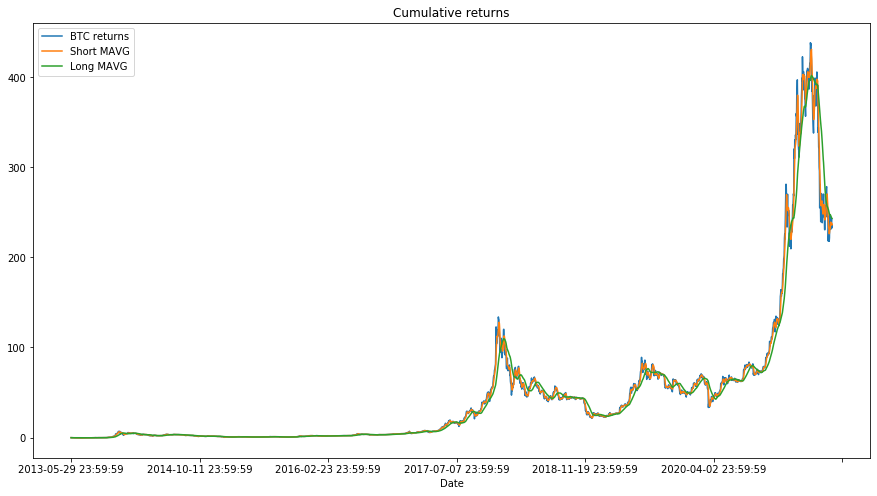

In [418]:
f,ax = plt.subplots(figsize=(15,8))

strat_summary['cum_ret'].plot(ax=ax, label='BTC returns')
strat_summary['short_mavg_ret'].plot(ax=ax, label='Short MAVG')
strat_summary['long_mavg_ret'].plot(ax=ax, label='Long MAVG')



ax.legend()
ax.set_title("Cumulative returns")


### Visualising strategy returns

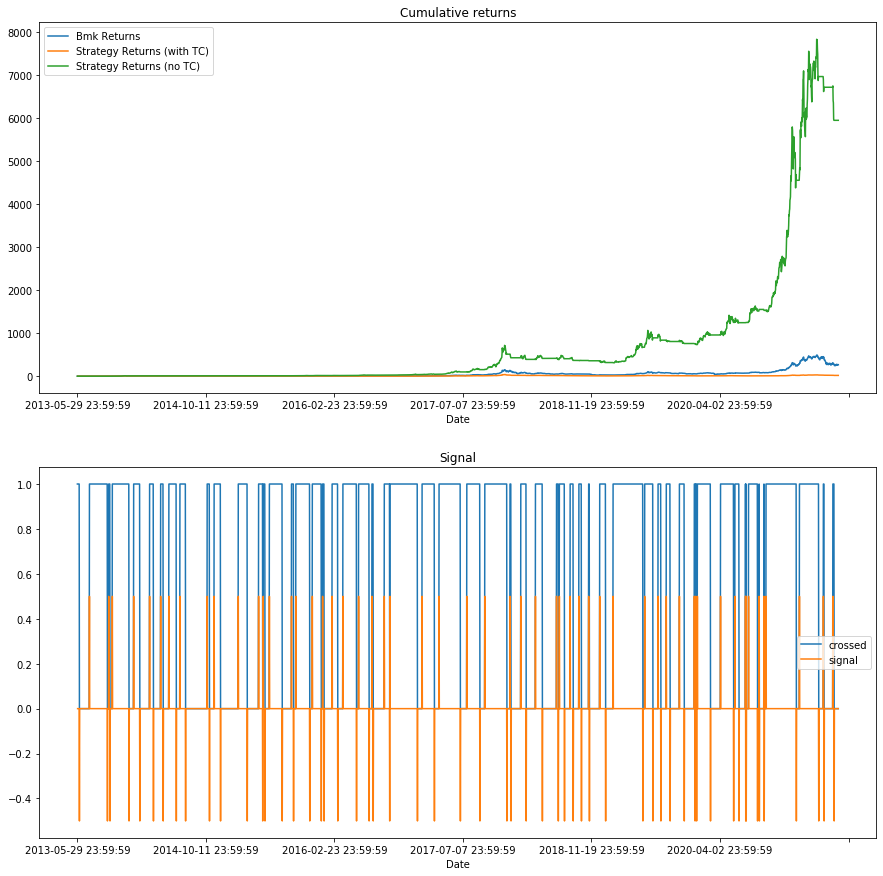

In [419]:
f,ax = plt.subplots(2,1,figsize=(15,15))

strat_summary['cum_bmk_ret'].plot(ax=ax[0], label='Bmk Returns')
strat_summary['cum_strat_ret'].plot(ax=ax[0], label='Strategy Returns (with TC)')
strat_summary['cum_strat_ret_no_tc'].plot(ax=ax[0], label='Strategy Returns (no TC)')


strat_summary['crossed'].plot(ax=ax[1], label='crossed')
(strat_summary['signal']/2).plot(ax=ax[1], label='signal')

ax[0].legend()
ax[0].set_title("Cumulative returns")

ax[1].set_title("Signal")
ax[1].legend()

### Active returns

These are the excess returns to the benchmark. Menaing how much the strategy did compared to simply holding bitcoins since inception.

- Handled with care: these calues of moving averages parameters might be overfitting the train set.
- Need to do things properly: train/test sets and run a backtest to find the right parameters without overfitting

If I invested $1 in bitcoin in 2013 I should get:

In [357]:
print("Bitcoing return over $1 = ",1 + strat_summary.iloc[-1,:]['cum_ret'])
print("Strategy return over $1 = ",1 + strat_summary.iloc[-1,:]['cum_strat_ret'])

Bitcoing return over $1 =  237.85619926235677
Strategy return over $1 =  18.111233447102713


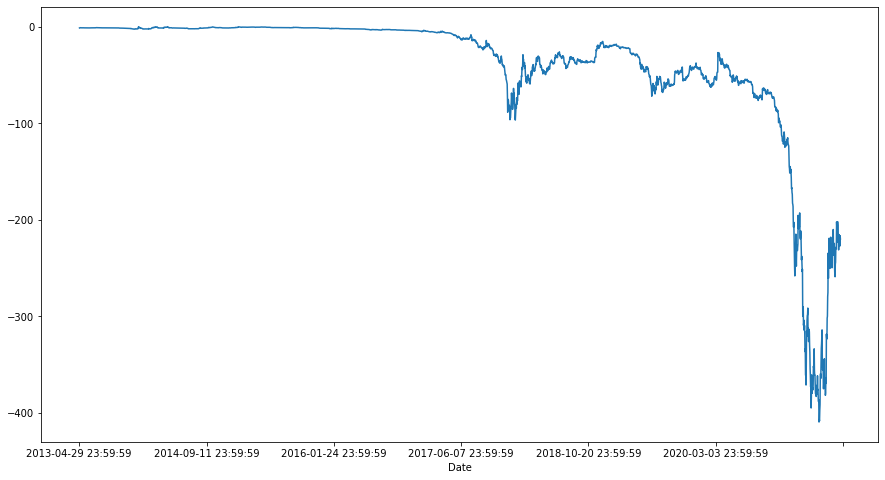

In [359]:
f,ax = plt.subplots(figsize=(15,8))
strat_summary.active_ret.plot()
# ret_df.loc[:'2017-01-01'].active_ret.plot()



# Cross validation

Objective function:

- I want to maximise returns given mavg parameters (lambda1, lambda2)

Starting with brute-force approach:

- Looping over differnet values of lambda
- Calculate compunded returns as metric
- Find combinations that give me maximum returns

In [420]:
X_train = ret_ts.loc[:'2019-01-01'].copy()


In [421]:
s_avg = np.arange(1, 30)
l_avg = np.arange(2,120)

In [424]:
res_list=[]
for s in s_avg:
    for l in l_avg:
        if s<l:
            
            X = mavg_strat(X_train, short_mavg=s, long_mavg=l, tc=0.05)
            strat_ret = X.iloc[-1]['cum_strat_ret']
            num_trans = X['signal'].abs().sum()
            
            res_tmp = pd.DataFrame({'s_avg': [s], 'l_avg':l, 'strat_ret':strat_ret, 'num_trans': num_trans})
            res_list.append(res_tmp)
            

res = pd.concat(res_list)            

In [427]:
res.sort_values('strat_ret')

,s_avg,l_avg,strat_ret,num_trans
0,1,2,-1.000000,1044.0
0,2,3,-1.000000,746.0
0,3,4,-1.000000,606.0
0,4,5,-1.000000,533.0
0,5,6,-1.000000,452.0
...,...,...,...,...
0,1,73,131.658558,68.0
0,1,87,136.323514,68.0
0,1,86,151.764021,64.0
0,1,85,151.764021,64.0


## Using optimized parametes 

- Testing out-of-sample
- Short avg = 1d
- Long avg = 84d

In [428]:
X_test =  ret_ts.loc['2019-01-01':].copy()

In [429]:
y_test = mavg_strat(X_test, short_mavg=1, long_mavg=84, tc=0.05)

In [430]:
y_test

,ret,cum_ret,short_mavg_ret,long_mavg_ret,crossed,signal,tc,tc_cum,num_trans,strat_ret_no_tc,cum_strat_ret_no_tc,cum_bmk_ret,strat_ret,cum_strat_ret,active_ret
Date,,,,,,,,,,,,,,,
2019-03-25 23:59:59,-0.014693,0.058880,0.058880,0.009864,1,NaN,NaN,NaN,37.0,-0.014693,-0.014693,-0.014693,NaN,NaN,NaN
2019-03-26 23:59:59,0.005554,0.064761,0.064761,0.010315,1,0.0,0.0,1.000000,37.0,0.005554,-0.009221,-0.009221,0.005554,0.005554,-0.059207
2019-03-27 23:59:59,0.025592,0.092010,0.092010,0.010772,1,0.0,0.0,1.000000,37.0,0.025592,0.016135,0.016135,0.025592,0.031288,-0.060722
2019-03-28 23:59:59,-0.004394,0.087212,0.087212,0.011511,1,0.0,0.0,1.000000,37.0,-0.004394,0.011670,0.011670,-0.004394,0.026756,-0.060455
2019-03-29 23:59:59,0.007193,0.095031,0.095031,0.012276,1,0.0,0.0,1.000000,37.0,0.007193,0.018947,0.018947,0.007193,0.034141,-0.060890
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-07-02 23:59:59,0.009679,8.056843,8.056843,11.004500,0,0.0,0.0,6.081407,37.0,0.000000,39.908001,7.427556,0.000000,5.424850,-2.631993
2021-07-03 23:59:59,0.022760,8.262977,8.262977,10.924583,0,0.0,0.0,6.081407,37.0,0.000000,39.908001,7.619368,0.000000,5.424850,-2.838127
2021-07-04 23:59:59,0.017861,8.428428,8.428428,10.845327,0,0.0,0.0,6.081407,37.0,0.000000,39.908001,7.773323,0.000000,5.424850,-3.003578


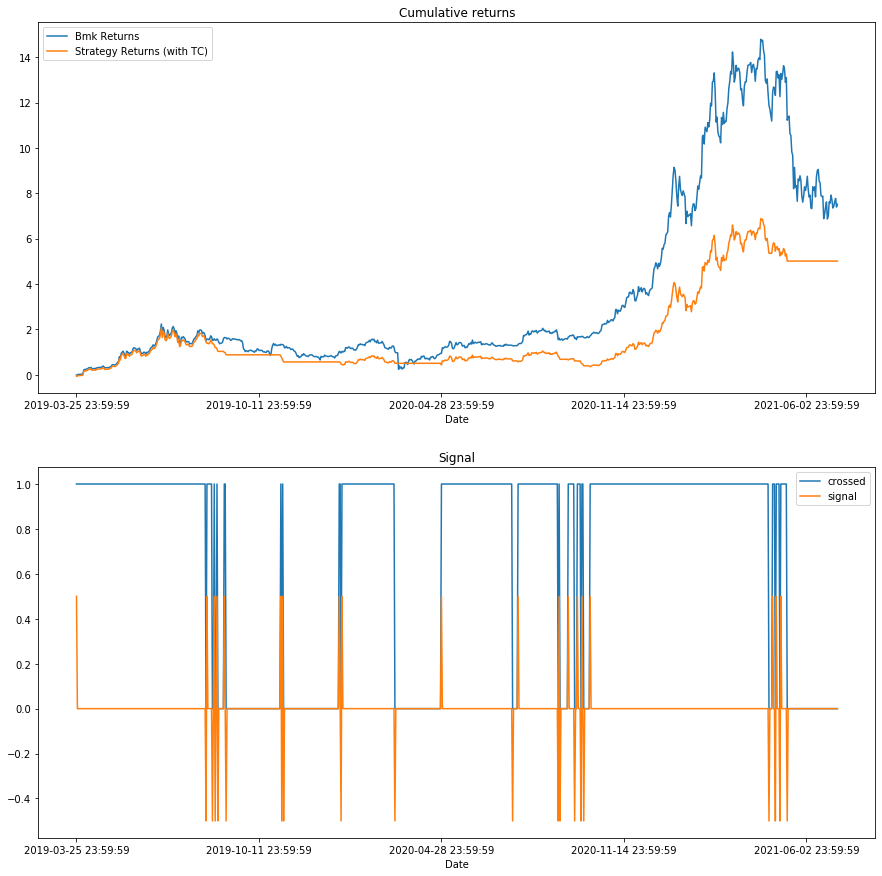

In [431]:
f,ax = plt.subplots(2,1,figsize=(15,15))

xx['cum_ret_bmk'].plot(ax=ax[0], label='Bmk Returns')
xx['cum_strat_ret'].plot(ax=ax[0], label='Strategy Returns (with TC)')
# y_test['cum_strat_ret_no_tc'].plot(ax=ax[0], label='Strategy Returns (no TC)')


xx['crossed'].plot(ax=ax[1], label='crossed')
(xx['signal']/2).plot(ax=ax[1], label='signal')

ax[0].legend()
ax[0].set_title("Cumulative returns")

ax[1].set_title("Signal")
ax[1].legend()